In [161]:
# import necessary libraries and set seed
import csv
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
np.random.seed(1337)

# initialize the dataframe to work on
cleaned_dataframe = pd.read_csv('original_election_data.csv')

# Bad data 

In [162]:
bad_cell_count = 0
for i in range(len(cleaned_dataframe)):
    check = 0
    for j in range(len(cleaned_dataframe.columns)):
        if '\n' in str(cleaned_dataframe.iloc[i, j]) or '<bound method Series.mean' in str(cleaned_dataframe.iloc[i, j]):
            cleaned_dataframe.iloc[i, j] = 0
            bad_cell_count+=1
print(f'bad_cell_count: {bad_cell_count}')


bad_cell_count: 5


### Split 

In [163]:
# when state FIPS code less than 10, four digit codes appear
fips = cleaned_dataframe['fips']
state_codes = []
county_codes = []
for val in fips:
    # print(type(str(val)))
    fip_code = str(val)
    if len(fip_code) == 4:
        state_codes.append('0'+fip_code[0])
        county_codes.append(fip_code[1:])
    elif len(fip_code) == 5:
        state_codes.append(fip_code[:2])
        county_codes.append(fip_code[2:])
        
# create temp dataframe for the new columns
state_county = pd.DataFrame({
    'State': state_codes,
    'County': county_codes
})

# concat state and county columns to the dataframe
cleaned_dataframe = pd.concat([state_county, cleaned_dataframe], axis=1)

### Aggregate 

In [164]:
# get education and religion columns
education = cleaned_dataframe.loc[:, 'Percent of adults with less than a high school diploma, 2011-2015':'Percent of adults with a bachelor\'s degree or higher, 2011-2015']
religion = cleaned_dataframe.loc[:, 'Amish':'Zoroastrian']

# create arrays consisting of column titles of largest numbers
max_education = education.idxmax(axis=1)
max_religion = religion.idxmax(axis=1)

# simplify max education names
for i in range(len(max_education)):
    # less than high school diploma
    # high school diploma only
    # some college
    # bachelors or higher
    if 'less than a high school diploma' in max_education[i]:
        max_education[i] = 'less than highschool diploma'
    elif 'high school diploma only' in max_education[i]:
        max_education[i] = 'highschool diploma only'
    elif 'some college' in max_education[i]:
        max_education[i] = 'some college'
    else: # bachelors+
        max_education[i] = 'bachelors or higher'


# at this point, max education and max religion arrays are prepped
# do work on the new data frame for replacement

# drop the old education features
cleaned_dataframe.drop('Percent of adults with less than a high school diploma, 2011-2015', axis=1, inplace=True)
cleaned_dataframe.drop('Percent of adults with a high school diploma only, 2011-2015', axis=1, inplace=True)
cleaned_dataframe.drop('Percent of adults completing some college or associate\'s degree, 2011-2015', axis=1, inplace=True)
cleaned_dataframe.drop('Percent of adults with a bachelor\'s degree or higher, 2011-2015', axis=1, inplace=True)

# drop the old religion features
cleaned_dataframe.drop(cleaned_dataframe.loc[:, 'Amish':'Zoroastrian'], axis=1, inplace=True)

# insert the new education and religion columns
cleaned_dataframe.insert(4, 'Education', max_education)
cleaned_dataframe.insert(7, 'Religion', max_religion)

# Aggregate age

# gather data
old_data = cleaned_dataframe.loc[:, '65-69_rate':'85+_rate'].sum(axis=1)
adult_data  = cleaned_dataframe.loc[:, '20-24_rate':'60-64_rate'].sum(axis=1)
young_data  = cleaned_dataframe.loc[:, '0-4_rate':'15-19_rate'].sum(axis=1)

# create dataframe for easier analysis
age_dataframe = pd.DataFrame({
    'Young': young_data,
    'Adult': adult_data,
    'Old': old_data
})

# create array for getting category label with largest element
age_data = age_dataframe.idxmax(axis=1)

# add the age column
cleaned_dataframe.insert(22, 'Age', age_data)

# ethnic aggregator
ethnic_male = cleaned_dataframe.loc[:, 'BLACK_MALE_rate':'MULTI_MALE_rate':2]
ethnic_female = cleaned_dataframe.loc[:, 'BLACK_FEMALE_rate':'MULTI_FEMALE_rate':2]

max_ethnic_male = ethnic_male.idxmax(axis=1)
max_ethnic_female = ethnic_female.idxmax(axis=1)


# drop specific ethnic male and female groups
cleaned_dataframe.drop(cleaned_dataframe.loc[:, 'BLACK_MALE_rate':'MULTI_FEMALE_rate'], axis=1, inplace=True)

# add in the max ethnic male and female rates
cleaned_dataframe.insert(44, 'EthnicFemale', max_ethnic_female)
cleaned_dataframe.insert(44, 'EthnicMale', max_ethnic_male)

# remove the specified features for the assignment
cleaned_dataframe.drop('PovertyUnder18Pct2014', axis=1, inplace=True)
cleaned_dataframe.drop('Deep_Pov_Children', axis=1, inplace=True)
cleaned_dataframe.drop('Housing units', axis=1, inplace=True)
cleaned_dataframe.drop('Area in square miles - Water area', axis=1, inplace=True)
cleaned_dataframe.drop('Area in square miles - Land area', axis=1, inplace=True)
cleaned_dataframe.drop('Density per square mile of land area - Housing units', axis=1, inplace=True)
cleaned_dataframe.drop('age_total_pop', axis=1, inplace=True)


### Rename 

In [165]:
# do inplace to edit the dataframe
cleaned_dataframe.rename(columns={
    'POP_ESTIMATE_2015':'PopulationEstimate2015',
    'Area in square miles - Total area':'TotalAreaSqM',
    'Density per square mile of land area - Population':'PopulationDensitySqM',
    }, inplace=True)

### Normalize 

In [166]:
# formula for z-score normalization is (value-mean)/standard_dev

median_household_inc = cleaned_dataframe['MedHHInc2014'].to_numpy()
per_capita_inc = cleaned_dataframe['PerCapitaInc'].to_numpy()
pop_est = cleaned_dataframe['PopulationEstimate2015'].to_numpy()
pop = cleaned_dataframe['Population'].to_numpy().astype(np.float)
area_sqM = cleaned_dataframe['TotalAreaSqM'].to_numpy()
pop_dense_sqM = cleaned_dataframe['PopulationDensitySqM'].to_numpy()

# get all means
med_inc_mean = np.mean(median_household_inc)
per_capita_inc_mean = np.mean(per_capita_inc)
pop_est_mean = np.mean(pop_est)
pop_mean = np.mean(pop)
area_sqM_mean = np.mean(area_sqM)
pop_dense_sqM_mean = np.mean(pop_dense_sqM)

# get all standard deviations
med_std = np.std(median_household_inc)
per_capita_std = np.std(per_capita_inc)
pop_est_std = np.std(pop_est)
pop_std = np.std(pop)
area_sqM_std = np.std(area_sqM)
pop_dense_sqM_std = np.std(pop_dense_sqM)


# Z-normalize the data
# normalized_med_hh_inc = []
# normalized_per_cap_inc = []

# for income in median_household_inc:
#     normalized_med_hh_inc.append((income-med_inc_mean)/med_std)

# for income in per_capita_inc:
#     normalized_per_cap_inc.append((income-per_capita_inc_mean)/per_capita_std)

# set the column values to the normalized ones
cleaned_dataframe['MedHHInc2014'] = (median_household_inc-med_inc_mean)/med_std
cleaned_dataframe['PerCapitaInc'] = (per_capita_inc-per_capita_inc_mean)/per_capita_std
cleaned_dataframe['PopulationEstimate2015'] = (pop_est-pop_est_mean)/pop_est_std
cleaned_dataframe['Population'] = (pop-pop_mean)/pop_std
cleaned_dataframe['TotalAreaSqM'] = (area_sqM-area_sqM_mean)/area_sqM_std
cleaned_dataframe['PopulationDensitySqM'] = (pop_dense_sqM-pop_dense_sqM_mean)/pop_dense_sqM_std

# add in rate features between 0 and 1
cleaned_dataframe['PovertyAllAgesPct2014'] = cleaned_dataframe['PovertyAllAgesPct2014'].to_numpy()/100
cleaned_dataframe['Deep_Pov_All'] = cleaned_dataframe['Deep_Pov_All'].to_numpy()/100
cleaned_dataframe['Unemployment_rate_2015'] = cleaned_dataframe['Unemployment_rate_2015'].to_numpy()/100
cleaned_dataframe['voter_turnout_rate']= cleaned_dataframe['voter_turnout_rate'].to_numpy()/100

### Summary 

In [167]:
# name, mean and standard deviation data
print(cleaned_dataframe.columns)
# data for PopulationEstimate2015
pop_estimate_mean = sum(cleaned_dataframe['PopulationEstimate2015'])/len(cleaned_dataframe['PopulationEstimate2015'])
pop_estimate_std_dev = np.std(cleaned_dataframe['PopulationEstimate2015'])

print('PopulationEstimate2015')
print(f'mean: {pop_estimate_mean}')
print(f'standard deviation: {pop_estimate_std_dev}')
print()# some separation between print blocks

# data for Population
pop_mean = pd.to_numeric(cleaned_dataframe['Population']).mean()
pop_std_dev = np.std(pd.to_numeric(cleaned_dataframe['Population']))

print('Population')
print(f'mean: {pop_mean}')
print(f'standard deviation: {pop_std_dev}')
print()

# calculate correlation score of PopulationEstimate2015 and Population
pop_est_np = cleaned_dataframe['PopulationEstimate2015'].to_numpy()
pop_np = cleaned_dataframe['Population'].to_numpy().astype(np.float)
numer1 = pop_est_np - pop_estimate_mean
numer2 = pop_np - pop_mean
numerator = np.sum(numer1*numer2)
denom1 = np.sum(numer1 ** 2)
denom2 = np.sum(numer2 ** 2)
denominator = np.sqrt(denom1*denom2)
r = numerator/denominator
print(f'correlation between Population and PopulationEstimate2015 is: {r}')

# correlation above 0.9, drop the estimate
cleaned_dataframe.drop('PopulationEstimate2015', axis=1, inplace=True)

print()

# name, median, quartiles, IQR (inter-quartile range) data

# PerCapitaInc
per_capita_inc_med = np.median(cleaned_dataframe['PerCapitaInc'])
per_capita_inc_quartiles = cleaned_dataframe['PerCapitaInc'].quantile([0.25, 0.5, 0.75])
per_capita_inc_IQR = per_capita_inc_quartiles[0.75] - per_capita_inc_quartiles[0.25]

print('PerCapitaInc')
print(f'median: {per_capita_inc_med}')
print(f'quartiles: {per_capita_inc_quartiles}')
print(f'IQR: {per_capita_inc_IQR}')
print()

# PovertyAllAgesPct2014
poverty_all_ages_med = np.median(cleaned_dataframe['PovertyAllAgesPct2014'])
poverty_all_ages_quartiles = cleaned_dataframe['PovertyAllAgesPct2014'].quantile([0.25, 0.5, 0.75])
poverty_all_ages_IQR = poverty_all_ages_quartiles[0.75] - poverty_all_ages_quartiles[0.25]

print('PovertyAllAgesPct2014')
print(f'median: {poverty_all_ages_med}')
print(f'quartiles: {poverty_all_ages_quartiles}')
print(f'IQR: {poverty_all_ages_IQR}')
print()


# mode of combined religion and ethnic male feature
mode_array = cleaned_dataframe['Religion'] + " " + cleaned_dataframe['EthnicMale']
mode = Counter(mode_array).most_common(1)
print(f'Mode of combined Religion and EthnicMale feature: {mode}')

Index(['State', 'County', 'fips', 'votes', 'Education',
       'Unemployment_rate_2015', 'PopulationEstimate2015', 'Religion',
       'MedHHInc2014', 'PerCapitaInc', 'PovertyAllAgesPct2014', 'Deep_Pov_All',
       'Population', 'TotalAreaSqM', 'PopulationDensitySqM', 'Age', '0-4_rate',
       '5-9_rate', '10-14_rate', '15-19_rate', '20-24_rate', '25-29_rate',
       '30-34_rate', '35-39_rate', '40-44_rate', '45-49_rate', '50-54_rate',
       '55-59_rate', '60-64_rate', '65-69_rate', '70-74_rate', '75-79_rate',
       '80-84_rate', '85+_rate', 'TOT_MALE_rate', 'TOT_FEMALE_rate',
       'WHITE_MALE_rate', 'EthnicMale', 'EthnicFemale', 'WHITE_FEMALE_rate',
       'WHITE_rate', 'BLACK_rate', 'NATIVE_AMERICAN_rate',
       'HAWAIIAN_PACIFIC_rate', 'MULTI_rate', 'voter_turnout_rate',
       'Democrat'],
      dtype='object')
PopulationEstimate2015
mean: 6.671928510465965e-18
standard deviation: 0.9999999999999991

Population
mean: -4.253795690535178e-17
standard deviation: 0.9999999999999992

###  Visualize

#### Histograms 

In [168]:
# set some parameters for plt
plt.figure(figsize=(8,4))

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

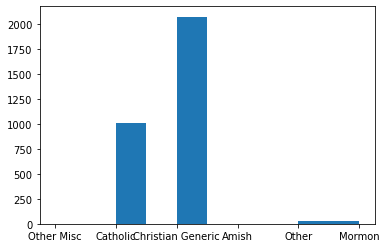

In [169]:
plt.hist(cleaned_dataframe['Religion'])
plt.show()

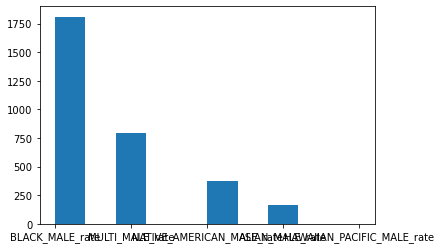

In [170]:
plt.hist(cleaned_dataframe['EthnicMale'])
plt.show()

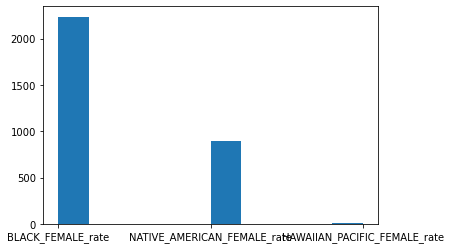

In [171]:
plt.hist(cleaned_dataframe['EthnicFemale'])
plt.show()

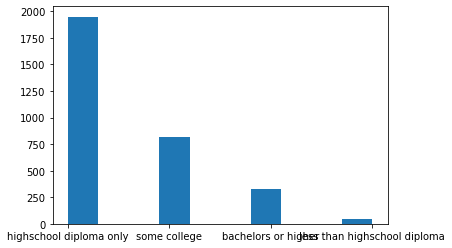

In [172]:
plt.hist(cleaned_dataframe['Education'])
plt.show()

#### Scatterplots

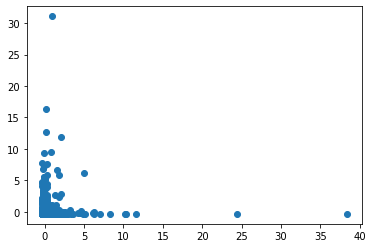

In [173]:
plt.scatter(x=cleaned_dataframe['TotalAreaSqM'],y=pd.to_numeric(cleaned_dataframe['Population']))
plt.show()

#### Boxplots 

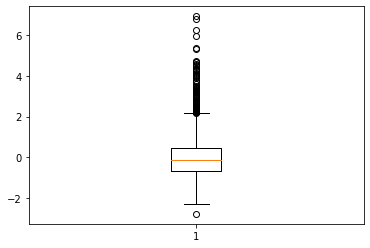

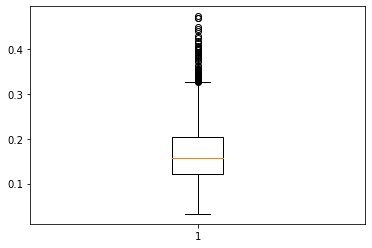

In [174]:
plt.boxplot(cleaned_dataframe['PerCapitaInc'])
plt.show()
plt.boxplot(cleaned_dataframe['PovertyAllAgesPct2014'])
plt.show()

### Output

In [175]:
# get rid of the age rate columns now (so won't affect earlier index-based insertions)
cleaned_dataframe.drop(cleaned_dataframe.loc[:, '0-4_rate':'85+_rate'], axis=1, inplace=True)

cleaned_dataframe.to_csv('elections_clean.csv', index=False)

### Conflict

To truly complete this section, I would have needed to find two rows which share the same values between features, but the outcome (label vector) would be different. For example, if two different rows shared the same value for Religion (say Generic Christian), and EthnicMale (say BLACK_MALE_rate), but the first row's was label vector value was democrat == 1 and the second's was democrat == 0, there would be a conflict between the two rows.

### Labels 

In this case, I'm pretty sure the label vector is just the Democrat feature on the very far right of the csv file. So all the other features are used in an attempt to predict whether or not the victor in that specific county within that state is a democrat or not.